## Final Classification Notebook

In [41]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.model_selection import train_test_split
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Under/Over-Sampling
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from collections import Counter

# Metrics
from sklearn.metrics import classification_report, confusion_matrix

In [42]:
# Loading the dataset
data_path = 'data.csv'
data = pd.read_csv(data_path)

#### Data Exploration

In [43]:
# Looking at the first 5 rows of the dataset and it's summary
data_head = data.head()
data_describe = data.describe()

data_head, data_describe

(   id                                            comment  score  sentiment
 0   1               What happened to sevilla, seriously?      1          0
 1   2           is tom huddlestone right or left footed?      1          0
 2   3  How highly rated was Deivid Washington at Sant...      1          0
 3   4  Yeah I thought you guys would go for more high...      1          0
 4   5  Never judge a player based on such limited gam...      1          0,
                  id         score     sentiment
 count  19282.000000  19282.000000  19282.000000
 mean    9641.500000      7.424800      0.162379
 std     5566.378281     44.088514      0.368808
 min        1.000000   -139.000000      0.000000
 25%     4821.250000      1.000000      0.000000
 50%     9641.500000      3.000000      0.000000
 75%    14461.750000      6.000000      0.000000
 max    19282.000000   2663.000000      1.000000)

In [44]:
# Looking at the value count and therefore the balance of classes
data_count = data['sentiment'].value_counts()

data_count

sentiment
0    16151
1     3131
Name: count, dtype: int64

In [45]:
# Checks to see if there are any missing values
missing_values = data.isnull().sum()

missing_values

id           0
comment      0
score        0
sentiment    0
dtype: int64

Next we will take a look at whether the score (the sum of upvotes and downvotes on a comment) shows any correlation whether it's harmful or not

In [46]:
correlation = data['score'].corr(data['sentiment'])

print(f"Correlation coefficient between score and sentiment: {correlation}")

Correlation coefficient between score and sentiment: 0.0050873506620956145


The result shows that there is no real relationship between score and sentiment, showing that harmful comments could equally be upvoted as much as downvoted. We can visualise this further with a scatter plot, where we can see both 0 or 1 sentiment typically sits in the same area in respect to it's score

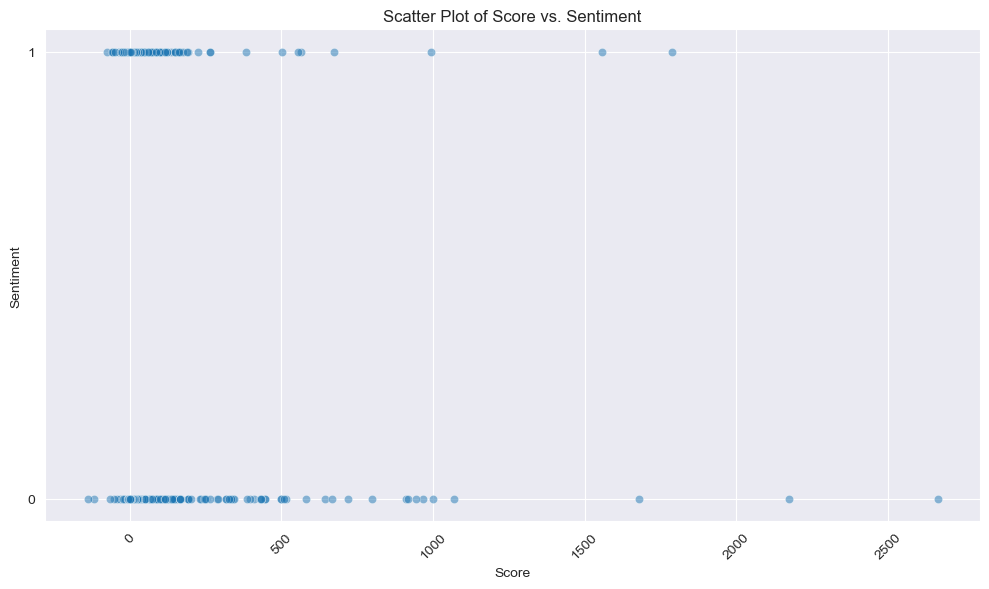

In [53]:
# Scatter plot to visualise the week connection
sns.set_style("darkgrid")
plt.figure(figsize=(10, 6)) 
sns.scatterplot(x='score', y='sentiment', data=data, alpha=0.5)

plt.title('Scatter Plot of Score vs. Sentiment')
plt.xlabel('Score')
plt.ylabel('Sentiment')
plt.xticks(rotation=45)
plt.yticks([0, 1])
plt.tight_layout()  

plt.show()

## Preprocessing

In [22]:
# Download necessary NLTK datasets
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\zakpl\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\zakpl\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [54]:
def clean_text(text):
    text = text.lower()  
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE) 
    text = re.sub(r'\W', ' ', text)  
    text = re.sub(r'\s+', ' ', text).strip()  
    return text

In [24]:
def preprocess_text(text):
    lemmatizer = WordNetLemmatizer()  
    text = clean_text(text)  
    tokens = text.split()
    processed_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stopwords.words('english')]
    return ' '.join(processed_tokens)

In [25]:
# Apply preprocessing
data['processed_comment'] = data['comment'].apply(preprocess_text)

# Display the first few rows of the processed data
data[['comment', 'processed_comment']].head()

,comment,processed_comment
0,"What happened to sevilla, seriously?",happened sevilla seriously
1,is tom huddlestone right or left footed?,tom huddlestone right left footed
2,How highly rated was Deivid Washington at Sant...,highly rated deivid washington santos two came...
3,Yeah I thought you guys would go for more high...,yeah thought guy would go high profile well kn...
4,Never judge a player based on such limited gam...,never judge player based limited gametime


In [26]:
# Initialise the TF-IDF vectorizer and then fit and transform
vectorizer = TfidfVectorizer()

X = vectorizer.fit_transform(data['processed_comment'])
y = data['sentiment'] # Target Variable

In [27]:
# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Creation

## Base Logistic Regression Model

In [55]:
# Initialise and train the base model
model = LogisticRegression()
model.fit(X_train, y_train)

# Test Set Predictions
y_pred = model.predict(X_test)

# Classification report for the model
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.90      1.00      0.95      3213
           1       1.00      0.45      0.62       644

    accuracy                           0.91      3857
   macro avg       0.95      0.72      0.78      3857
weighted avg       0.92      0.91      0.89      3857

Confusion Matrix:
 [[3213    0]
 [ 355  289]]


## Logistic Regression with GridSearchCV

In [56]:
# Initialise the model with liblinear solver and set a parameters grid
model = LogisticRegression(solver='liblinear')
param_grid = {
    'penalty': ['l1', 'l2'], 
    'C': [0.01, 0.1, 1, 10, 100] 
}

In [57]:
# Setup and fit the Grid Search 
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='f1_macro', verbose=2)
grid_search.fit(X_train, y_train)

# Print the best parameters found
print("Best parameters found: ", grid_search.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END .................................C=0.01, penalty=l1; total time=   0.0s
[CV] END .................................C=0.01, penalty=l1; total time=   0.0s
[CV] END .................................C=0.01, penalty=l1; total time=   0.0s
[CV] END .................................C=0.01, penalty=l1; total time=   0.0s
[CV] END .................................C=0.01, penalty=l1; total time=   0.0s
[CV] END .................................C=0.01, penalty=l2; total time=   0.0s
[CV] END .................................C=0.01, penalty=l2; total time=   0.0s
[CV] END .................................C=0.01, penalty=l2; total time=   0.0s
[CV] END .................................C=0.01, penalty=l2; total time=   0.0s
[CV] END .................................C=0.01, penalty=l2; total time=   0.0s
[CV] END ..................................C=0.1, penalty=l1; total time=   0.0s
[CV] END ..................................C=0.1

In [58]:
# Make predictions on the test set using the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Classification report for the best model
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.98      0.96      3213
           1       0.90      0.73      0.80       644

    accuracy                           0.94      3857
   macro avg       0.92      0.85      0.88      3857
weighted avg       0.94      0.94      0.94      3857

Confusion Matrix:
 [[3159   54]
 [ 176  468]]


In [59]:
scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train)

print('Original dataset shape %s' % Counter(y_train))

Original dataset shape Counter({0: 12938, 1: 2487})


In [60]:
# Apply SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train_scaled, y_train)

print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({1: 12938, 0: 12938})


In [61]:
grid_search.fit(X_res, y_res)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END .................................C=0.01, penalty=l1; total time=   0.0s
[CV] END .................................C=0.01, penalty=l1; total time=   0.0s
[CV] END .................................C=0.01, penalty=l1; total time=   0.0s
[CV] END .................................C=0.01, penalty=l1; total time=   0.0s
[CV] END .................................C=0.01, penalty=l1; total time=   0.0s
[CV] END .................................C=0.01, penalty=l2; total time=   0.1s
[CV] END .................................C=0.01, penalty=l2; total time=   0.2s
[CV] END .................................C=0.01, penalty=l2; total time=   0.2s
[CV] END .................................C=0.01, penalty=l2; total time=   0.2s
[CV] END .................................C=0.01, penalty=l2; total time=   0.2s
[CV] END ..................................C=0.1, penalty=l1; total time=   0.1s
[CV] END ..................................C=0.1

C:\Users\zakpl\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ...................................C=10, penalty=l1; total time=   4.1s
[CV] END ...................................C=10, penalty=l1; total time=   0.7s
[CV] END ...................................C=10, penalty=l1; total time=   0.1s
[CV] END ...................................C=10, penalty=l2; total time=   0.4s
[CV] END ...................................C=10, penalty=l2; total time=   1.0s
[CV] END ...................................C=10, penalty=l2; total time=   0.8s
[CV] END ...................................C=10, penalty=l2; total time=   0.8s
[CV] END ...................................C=10, penalty=l2; total time=   0.9s


C:\Users\zakpl\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ..................................C=100, penalty=l1; total time=   2.5s


C:\Users\zakpl\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ..................................C=100, penalty=l1; total time=   2.8s


C:\Users\zakpl\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ..................................C=100, penalty=l1; total time=   3.7s


C:\Users\zakpl\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ..................................C=100, penalty=l1; total time=   2.1s


C:\Users\zakpl\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ..................................C=100, penalty=l1; total time=   2.2s
[CV] END ..................................C=100, penalty=l2; total time=   0.7s
[CV] END ..................................C=100, penalty=l2; total time=   1.2s
[CV] END ..................................C=100, penalty=l2; total time=   1.4s
[CV] END ..................................C=100, penalty=l2; total time=   1.5s
[CV] END ..................................C=100, penalty=l2; total time=   1.6s


GridSearchCV(cv=5, estimator=LogisticRegression(solver='liblinear'),
             param_grid={'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2']},
             scoring='f1_macro', verbose=2)

In [62]:
# Use the best estimator directly
best_model = grid_search.best_estimator_

# Scale the test set without fitting (use the previously fitted scaler)
X_test_scaled = scaler.transform(X_test)

# Predict on the scaled and resampled test data
y_pred = best_model.predict(X_test_scaled)

# Evaluate the best model
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95      3213
           1       0.76      0.73      0.75       644

    accuracy                           0.92      3857
   macro avg       0.85      0.84      0.85      3857
weighted avg       0.92      0.92      0.92      3857

Confusion Matrix:
 [[3067  146]
 [ 173  471]]
